In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), "../src"))
from utils import *

In [2]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torchsummary import summary

import matplotlib.pyplot as plt
%matplotlib inline

## 1. Creating a simple dataset using the linear regression formula

We'll use a linear regression to make a straight line with known parameters and see if the neural network can learn these parameters

In [3]:
weight, bias = 0.7, 0.3
start, end, step = 0, 1, 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1) #Needed for modelling
y = weight * X  + bias
X.shape, y.shape

(torch.Size([50, 1]), torch.Size([50, 1]))

## 2. Train-test split

In [4]:
from sklearn.model_selection import train_test_split

SEED = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = SEED)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


(torch.Size([40, 1]),
 torch.Size([10, 1]),
 torch.Size([40, 1]),
 torch.Size([10, 1]))

## 3. Visualize data

In [31]:
def plot_predictions(train_data = X_train,
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions = None):
    """Plots training data, test data and compares predictions

    Args:
        train_data (_type_, optional): _description_. Defaults to X_train.
        train_labels (_type_, optional): _description_. Defaults to y_train.
        test_data (_type_, optional): _description_. Defaults to X_test.
        test_labels (_type_, optional): _description_. Defaults to y_test.
        predictions (_type_, optional): _description_. Defaults to None.
    """
    
    plt.figure(figsize=(10,7))
    plt.scatter(train_data, train_labels, c="b",s=4,
                label = "Training data")
    plt.scatter(test_data, test_labels, c="r", s=4, label="Testing data")
    plt.ylabel('y')
    plt.xlabel('X')
    if predictions is not None:
        plt.scatter(test_data, predictions, c = "k", s=4, label="Model predictions")
    plt.legend()

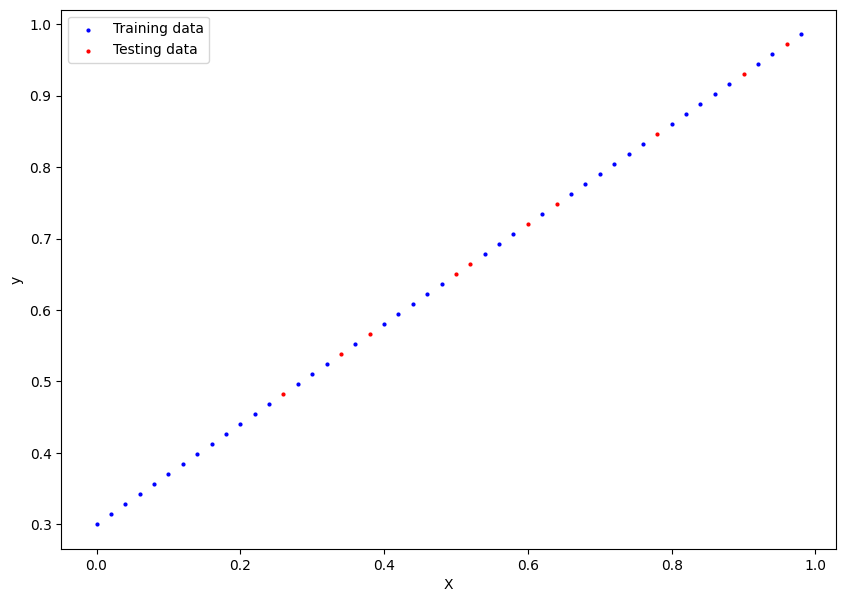

In [32]:
plot_predictions()

## 3. Creating our first PyTorch Model for Linear Regression
The weights and bias are randomly initialized and updated with each epoch.

In [39]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.rand(1,
                                               requires_grad=True,
                                               dtype=torch.float))
        self.bias = nn.Parameter(torch.rand(1,
                                            requires_grad=True,
                                            dtype=torch.float))
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        # Must always overwrite the nn.Module's forward function
        return self.weights * X + self.bias

In [40]:
SEED = 42
torch.manual_seed(SEED)
device = get_device()
model = LinearRegressionModel()
device, model

('mps', LinearRegressionModel())

In [41]:
list(model.parameters())

[Parameter containing:
 tensor([0.8823], requires_grad=True),
 Parameter containing:
 tensor([0.9150], requires_grad=True)]

The model's state_dict contains the name of the parameter and the value

In [42]:
model.state_dict()

OrderedDict([('weights', tensor([0.8823])), ('bias', tensor([0.9150]))])

## 4. Making predictions with our randomly initialized model using inference mode

In [34]:
model(X_test)

tensor([[1.1444],
        [1.6032],
        [1.4444],
        [1.7090],
        [1.2150],
        [1.7620],
        [1.3738],
        [1.3561],
        [1.4797],
        [1.2503]], grad_fn=<AddBackward0>)

The gradient is still tracked here.

Can overcome this either by using
* `torch.no_grad` or
* `torch.inference_mode`

`torch.inference_mode` is preferred in this context due to better performance as it disables view tracking and version counter bumps.

`torch.no_grad` is used if you want to set the attribute on tensors back to `requires_grad`.

In [24]:
with torch.inference_mode(): #This turns off the gradient update
    y_preds = model(X_test)

y_preds

tensor([[1.1444],
        [1.6032],
        [1.4444],
        [1.7090],
        [1.2150],
        [1.7620],
        [1.3738],
        [1.3561],
        [1.4797],
        [1.2503]])

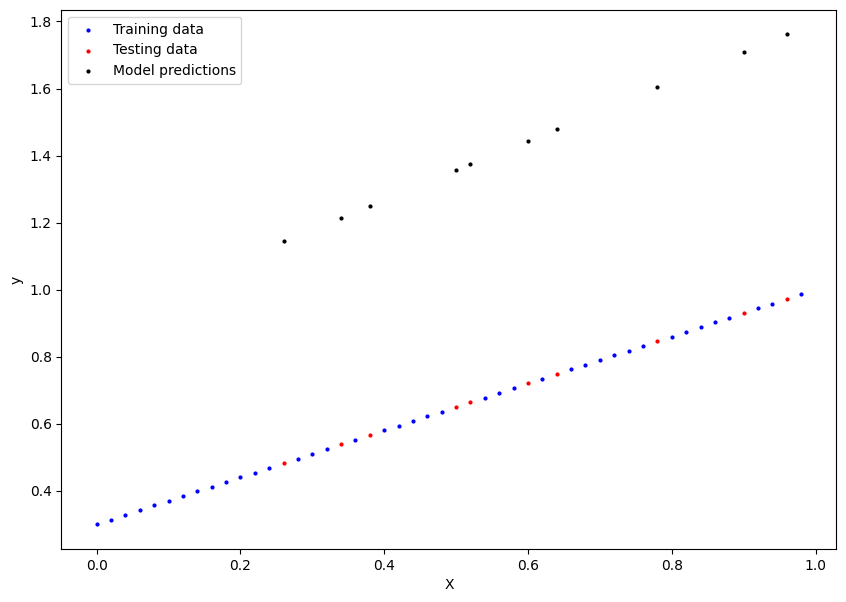

In [33]:
plot_predictions(predictions = y_preds)

## 5. Training the model to see if we can get the ideal parameters for linear regression
Here are some things we will need for model training:
* The loss function we're trying to optimize is MAE, which is `torch.nn.L1Loss`.
* We need an optimizer
* Training loop (specific to PyTorch)
* Testing loop (specific to PyTorch)

In [37]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.01)

### Building training and testing loops in PyTorch
We need to: 
* Loop through the data
* Forward pass (involves data moving through our model's `forward` function)
* Compute loss (compare forward pass predictions to ground truth labels)
* Optimizer zero grad
* Backpropogation - move backwards to calculate the gradients of each of the parameters of our model with respect to the loss.
* Optimizer step - use the optimizer to reduce the value of the loss function by gradient descent 

In [38]:
epochs = 100 #An epoch refers to one loop (pass) through the data
epoch_set, train_loss, test_loss = [], [], []
torch.manual_seed(SEED)

for epoch in range(epochs):
    # Set the model to training mode (all parameters -> requires grad)
    model.train()
    
    # Forward pass
    y_pred = model(X_train)
    
    # Compute loss
    loss = loss_fn(y_pred, y_train)
    
    # Optimizer zero grad
    optimizer.zero_grad()
    
    # Back propogation
    loss.backward()
    
    # Perform gradient descent - the optimizer's changes accumulate
    # through the loop. So we have to zero them above to start fresh
    # for each pass through the loop
    optimizer.step()
    
    print(model.state_dict())
    
    # Turn the model to evaluation mode
    model.eval()
    
    # Turn off requires_grad flag and makes PyTorch run faster
    # torch.no_grad is used for older PyTorch versions
    with torch.inference_mode():
        
        # Get prediction on test set
        test_pred = model(X_test)
        
        # Compute loss on test set
        test_loss = loss_fn(test_pred, y_test)
        
        if epoch %10 == 0:
            epoch_set.append(epoch)
            train_loss.append(loss.detatch().numpy())
            test_loss.append(test_loss.detatch().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss}")
    

OrderedDict([('weights', tensor([0.8776])), ('bias', tensor([0.9050]))])
